# TODO:

- [ ] Move `savefig` out of heatmaps
- [ ] Make all plot functiions have standard format
```python
def my_plot(ax, data, param_dict)
    Generate plot
    return ax.plot(data, **param_dict)
```
- [ ] Then call it as follows:
```python
data = some_file
fig, ax = plt.subplots()
my_plot(ax, data, {'marker': 'x'})
```
```
- [ ] Make matplotlib widget default plotting parameter on local machine
- [ ] Refactor notebook
    - [ ] Move all functions to dedicated module `heatmaps.py`
    - [ ] Main function call is `heatmap()` that takes structred data as input
        - [ ] Make conversion of .csv to dataframe a separate function
    - [ ] Bonus: make function callable from command line that takes list of csv files
        - `% python heatmap -f file1.csv ... fileN.csv -o output.png`
        - output figure should use science, nature theme automatically, but user can override mplstyles

In [2]:
# File handling and sorting
from glob import glob
import os
import datetime


# Math and plotting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
# import matplotlib.patches as patches
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import axes_grid1
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.ndimage import zoom

# https://github.com/garrettj403/SciencePlots
matplotlib.rcParams.update(matplotlib.rcParamsDefault) # Reset user themes
plt.style.use(['science']) # Figures sized for publication
# plt.style.use('notebook') # Large figures for notebook display

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs): # See https://nbviewer.jupyter.org/github/mgeier/python-audio/blob/master/plotting/matplotlib-colorbar.ipynb
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def heat_map(files, npx, npy, stepx, stepy, zmin, zmax, start, end):
    # Generate physical grid of plotted region based on user input
    x = np.linspace(0, (npx-1)*stepx, npx)
    y = np.linspace(0, (npy-1)*stepy, npy)
    XX, YY = np.meshgrid(x, y)

    # Check if number of files matches expected grid mesh
    if npx*npy == len(files):
        # Get the counts for each file
        Z = []
        for file in files:
            df = pd.read_csv(file, header = None)
            df.columns = ['wavelength', 'counts']
            Z = Z + [df.counts]
    else:
        raise TypeError('Number of files does not match specificied gridsize')

    # Gather the sum of counts in a select Region of Interest (ROI)
    #    Start: index in df corresponding to beginning of ROI
    #    End:   index in df corresponding to end of ROI
    I = [line[start:end].sum() for line in Z]
    I = np.array(I)
    I = I.reshape((npy,npx))

    # Display sample spectrum with integration region overlay
    fig = plt.figure()
    # plt.plot(df.wavelength.apply(nm_to_cmm1), df.counts)
    plt.plot(df.wavelength, df.counts)
    # plt.ylim(0,np.amax(df.counts[start:end])*1.2)
    plt.ylim(0,np.amax(df.counts)*1.2)
    # plt.scatter(df.wavelength.apply(nm_to_cmm1)[start:end], np.ones(end - start)*1000, marker='|', s=100000 , color=(0.5,0.5,0.5,0.4))
    plt.scatter(df.wavelength[start:end], np.ones(end - start)*100, marker='|', s=100000 , color=(0.5,0.5,0.5,0.4))
    plt.title('Integration Region')
    # plt.xlabel('Raman shift (cm$^{-1}$)')
    plt.xlabel('Wavelength (nm)')
    plt.show()

    # Display heat map
    plt.figure()
    heatmap = plt.pcolormesh(XX, YY, I, vmin=zmin, vmax=zmax, shading='auto', cmap='RdBu_r'); 
    plt.gca().set_aspect('equal')
    # plt.colorbar()
    add_colorbar(heatmap)
    # plt.xlabel('x (um)'); plt.ylabel('y (um)')
    plt.xlim(0, (npx-1)*stepx)
    plt.ylim((npy-1)*stepy, 0)
    # plt.axes('off')
    
    plt.show()

# Heat Maps

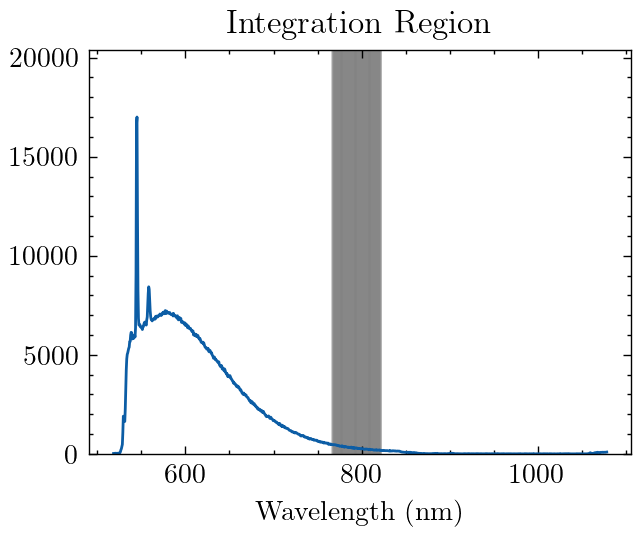

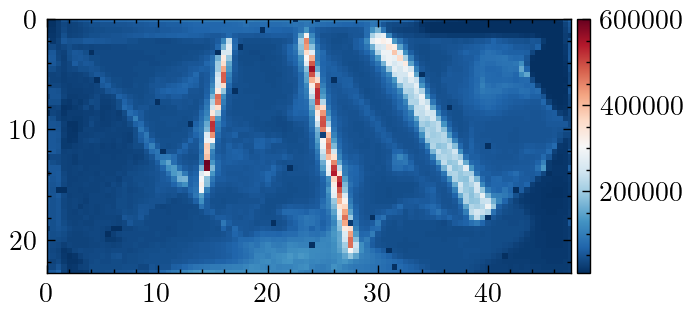

In [3]:
files = glob('data/*.csv')
# files = sorted(files, key = os.path.getmtime)
files = sorted(files)
title = 'Integrated Intensity'
# print(len(files))

# Specify conditions of collected data
npx = 96  # num pixels in x dir
stepx = 0.5  # step size in microns
npy = 47  # num pixels in y dir
stepy = 0.5  # step size in microns
zmin = 1e4  # minimum intensity to show
zmax = 6e5  # maximum intensity to show
start = 450
end = 550

# Make plot
heat_map(files, npx, npy, stepx, stepy, zmin, zmax, start, end)